### **Notebook to make predictions with reprocessed Yoneda and Henson data and EFLUX2 and SPOT** 

##### **Import python packages**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
%matplotlib inline
from matplotlib import pyplot as plt
from edd_utils import login, export_study, export_metadata

##### **Load data**

In [2]:
# Study to Download
study_slug = 'biodesign_henson2018_reprocessed'#multiomics-data-for-wt-strain-c157'
# EDD server
edd_server = 'public-edd.jbei.org'#agilebiofoundry.org'#'edd.jbei.org'
user       = 'schenkch'#cschenk@bcamath.org'#'schenkch'

In [5]:
session = login(edd_server=edd_server, user=user)

Password for schenkch:  ···············


In [6]:
df = export_study(session, study_slug, edd_server=edd_server)
df.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,20.0
1,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,32.0
2,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,20.0
3,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,32.0
4,14409,Biodesign_Henson2018_reprocessed,14907,WT-M-R3,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14950,WT-M-R3,NaN,WP_000104864_1,0,FPKM,0.0,20.0


##### **Filter data from all EDD data into different dataframes**

In [7]:
df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
df_Trans.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,20.0
1,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,32.0
2,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,20.0
3,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,32.0
4,14409,Biodesign_Henson2018_reprocessed,14907,WT-M-R3,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14950,WT-M-R3,NaN,WP_000104864_1,0,FPKM,0.0,20.0


##### **Load Genome Scale Model**

In [8]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import Joonhoons Code**

In [9]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from eflux2 import EFlux2
from spot_cplex import SPOT #spot not working yet because quadratic constraints not supported yet

##### Change gene annotation from WP... to G_WP..., such that the model and dataframe annotations match

In [10]:
df_Trans2 = df_Trans.copy()
df_Trans2.loc[:,'Measurement Type'] = df_Trans2.loc[:,'Measurement Type'].apply(lambda x: x.replace('WP', 'G_WP'))

#### **EFLUX2 and SPOT Predictions**

##### **Non modularized way ( Can be removed when we know that it works!!!)**

In [11]:
# #for index in growthandsubstrdata.index:
with model:
    #display(model.medium)
    medium = model.medium
    #         if '-P-' in index:
    # #             model.objective = 'Growth_Phenol'
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    medium["EX_glc__D_e"] = 0.0
    medium["EX_phenol_e"] = 100#sub_uptake_rate
    model.medium = medium
    #display(model.medium)
    eflux2sol_WTPR1 = EFlux2(model, df_Trans2[df_Trans2['Line Name']=='WT-P-R1'])
    display(eflux2sol_WTPR1)
    spotsolWTPR1 = SPOT(model, df_Trans2[df_Trans2['Line Name']=='WT-P-R1'])
    display(spotsolWTPR1)
#         else:
# #             model.objective = 'Growth_Glucose'
#             model.objective = 'Growth'
#             sub_uptake_rate = 1.76124#growthandsubstrdata.loc[index,'substrate_consumption_rate']
#             medium["EX_glc__D_e"] = sub_uptake_rate
#             medium["EX_phenol_e"] = 0.0
#             #print(index)
#             #print(index)
#         model.medium = medium

FBA status optimal
FBA solution 0.23577895481228875
EFlux2 status optimal
EFlux2 solution 1100.107625001566


,fluxes,reduced_costs
12DGR120tipp,0.000000,1.161130e+03
12DGR140tipp,0.000000,1.161130e+03
12DGR141tipp,0.000000,0.000000e+00
12DGR161tipp,0.000000,0.000000e+00
12DGR180tipp,0.000000,0.000000e+00
...,...,...
EX_phenol_e,-2.468960,0.000000e+00
phenol_transport,2.468960,0.000000e+00
PHEMOX,2.468960,-8.415696e-14
Growth_Phenol,0.235779,4.447211e+04


12DGR120tipp        0.000567
12DGR140tipp        0.000567
12DGR141tipp        0.000567
12DGR161tipp        0.000567
12DGR180tipp        0.000567
                      ...   
EX_phenol_e        -0.056697
phenol_transport    0.056697
PHEMOX              0.056697
Growth_Phenol       0.000465
Growth_Glucose      0.000000
Length: 2385, dtype: float64

In [24]:
from optlang.symbolics import add
"""
    Provides EFLUX2 predictions as explained in Machado et. al (2014) 
    
        Parameters
        ----------
        model : cobrapy model.
        Transcriptomics : pandas dataframe with transcriptomics data.
        
        Returns
        -------
        eflux2_sol as output from eflux2_model.optimize().
        
"""
#Code only works for GPRs written in disjunctive normal form (DNF). Majority of models have them in DNF but there are some exceptions. 

def EFlux2test(model, Transcriptomics):
    with model as eflux2_model:
        #eflux2_model = model.copy()
        # Parse GPR into a dict containing isozymes (separated by 'or')
        # Each isozyme has a set of subunits (separated by 'and')
        #'and' and 'or' can occur at the same time, or can occur by itself.
        gpr_dict = dict()
        for r in eflux2_model.reactions:
            if r.gene_reaction_rule:
                temp = set()
                for x in [x.strip('() ') for x in r.gene_reaction_rule.split(' or ')]:
                    temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
                gpr_dict[r.id] = temp
        # Set the bounds using the transcriptomics data
        for r in eflux2_model.reactions:
            if r.gene_reaction_rule:
                #If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
                #If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
                #If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
                t = np.sum([np.min([Transcriptomics.loc[g] if g in Transcriptomics.index
                                    else np.array([np.Inf]) for g in p])
                            for p in gpr_dict[r.id]])
                if r.lower_bound < 0.0:
                    r.lower_bound = -t
                else:
                    pass
                if r.upper_bound > 0.0:
                    r.upper_bound = t
                else:
                    pass
            else:
                #When there is no GPR, the arbitrary bounds are removed. 
                #Common arbitrary bound value of 1000 for E.coli, might be different depending on the model, e.g., 99999.0 for iMM904 yeast model in BiGG
                if r.lower_bound <= -1000.0:
                    r.lower_bound = -np.Inf
                if r.upper_bound >= 1000.0:
                    r.upper_bound = np.Inf     
        display(model.medium)
        # solve FBA to calculate the maximum biomass
        eflux2_model.tolerance = 1e-9
        fba_sol = eflux2_model.optimize()
        print('FBA status', fba_sol.status)
        print('FBA solution', fba_sol.objective_value)
        # Constrain the biomass to the optimal value
        for r in eflux2_model.reactions:
            if r.objective_coefficient:
                r.lower_bound = fba_sol.objective_value
        # minimize the sum of squared flux values
        eflux2_model.objective = eflux2_model.problem.Objective(add([r.flux_expression**2 for r in eflux2_model.reactions]), direction='min')
        eflux2_sol = eflux2_model.optimize()
        print('EFlux2 status', eflux2_sol.status)
        print('EFlux2 solution', eflux2_sol.objective_value)
    # return eflux2 solution
    return eflux2_sol

In [25]:
# eflux2sol_WTPR1, spotsol_WTPR1 = eflux2spotpred(model, df_Trans2, 'WT-P-R1', 'phenol', 100)
# eflux2sol_WTPR2, spotsol_WTPR2 = eflux2spotpred(model, df_Trans2, 'WT-P-R2', 'phenol', 100)
# eflux2sol_WTPR3, spotsol_WTPR3 = eflux2spotpred(model, df_Trans2, 'WT-P-R3', 'phenol', 100)

In [26]:
# eflux2sol_WTPR1.fluxes

In [27]:
# eflux2sol_WTPR1_df = pd.DataFrame(eflux2sol_WTPR1.fluxes, columns=['fluxes'])
# eflux2sol_WTPR2_df = pd.DataFrame(eflux2sol_WTPR2.fluxes, columns=['fluxes'])
# eflux2sol_WTPR3_df = pd.DataFrame(eflux2sol_WTPR3.fluxes, columns=['fluxes'])
# eflux2sol_WTPR = pd.concat([eflux2sol_WTPR1_df, eflux2sol_WTPR2_df, eflux2sol_WTPR3_df], axis=1)
# eflux2sol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
# eflux2sol_WTPR.mean(axis=1)
# eflux2sol_WTPR.std(axis=1)


In [28]:
# eflux2sol_WTPR

##### **Modularized way**

In [29]:
#Function for EFLUX2 and SPOT Predictions:
def eflux2spotpred(model, transcriptdf, linename, substrate, sub_uptake_rate):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium["EX_glc__D_e"] = 0.0
            medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        eflux2sol = EFlux2test(model, transcriptdf[transcriptdf['Line Name']==linename])
        spotsol = SPOT(model, transcriptdf[transcriptdf['Line Name']==linename])
    return eflux2sol, spotsol

In [30]:
# eflux2sol_WTPR1, spotsol_WTPR1 = eflux2spotpred(model, df_Trans2, 'WT-P-R1', 'phenol', 100)

In [31]:
#display(eflux2sol_WTPR1.fluxes['Growth_Phenol'])

In [32]:
#spotsol_WTPR1df =pd.DataFrame(spotsol_WTPR1, columns=['fluxes'])
#spotsol_WTPR1df

In [33]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def eflux2spotpredthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    eflux2sol_R1, spotsol_R1 = eflux2spotpred(model, df_Trans2, linename1, 'phenol', 100)
    eflux2sol_R2, spotsol_R2 = eflux2spotpred(model, df_Trans2, linename2, 'phenol', 100)
    eflux2sol_R3, spotsol_R3 = eflux2spotpred(model, df_Trans2, linename3, 'phenol', 100)
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)
    #eflux2sol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    #SPOT calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    #spotsol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
    spotsol = spotsol_all.mean(axis=1)
    spotsol_std = spotsol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std, spotsol, spotsol_std

In [34]:
eflux2sol, eflux2sol_std, spotsol, spotsol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)
#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

{'EX_h2o_e': 10.0,
 'EX_h_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_fe3_e': 10.0,
 'EX_k_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_cobalt2_e': 10.0,
 'EX_zn2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_o2_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_mobd_e': 10.0,
 'EX_so4_e': 10.0,
 'EX_phenol_e': 100}

FBA status optimal
FBA solution 0.23577895481228875
EFlux2 status optimal
EFlux2 solution 1100.107625001566


{'EX_h2o_e': 10.0,
 'EX_h_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_fe3_e': 10.0,
 'EX_k_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_cobalt2_e': 10.0,
 'EX_zn2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_o2_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_mobd_e': 10.0,
 'EX_so4_e': 10.0,
 'EX_phenol_e': 100}

FBA status optimal
FBA solution 0.23577895481229008
EFlux2 status optimal
EFlux2 solution 1100.1076250147712


{'EX_h2o_e': 10.0,
 'EX_h_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_fe3_e': 10.0,
 'EX_k_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_cobalt2_e': 10.0,
 'EX_zn2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_o2_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_mobd_e': 10.0,
 'EX_so4_e': 10.0,
 'EX_phenol_e': 100}

FBA status optimal
FBA solution 0.23577895481229008
EFlux2 status optimal
EFlux2 solution 1100.1076250147712


In [35]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['fluxes'])
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['fluxes'])

#### **Plot solutions: Comparison of SPOT and EFLUX2 solution**

##### **Load 13cdata**

####  **Get 13C MFA measured fluxes for phenol**

In [36]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')
phenol_fluxes.dropna(inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

There are 29 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,1.000000e+02,1.000000e+02,100.0000
1,TCA Cycle,PDH,Pyr <-> AcCoA + CO2 + NADH,5.923270e+01,5.668260e+01,62.0459
2,TCA Cycle,CS or reverse_CITL,OAC + AcCoA -> Cit,1.144391e+02,1.102766e+02,118.4800
3,TCA Cycle,ACONT or ( ACONTa and ACONTb),Cit -> ICit,1.144391e+02,1.102766e+02,118.4800
4,TCA Cycle,ICDHx or ICDHyr,ICit -> AKG + CO2 + NADPH,1.134677e+02,1.068011e+02,118.4800
5,TCA Cycle,AKGDH or OOR3r,AKG -> SucCoA + CO2 + NADH,1.086053e+02,1.017297e+02,113.8305
6,TCA Cycle,3OADPCOAT or OCOAT3r or SUCBZT1 or SUCBZT2 or ...,SucCoA -> Suc + ATP,2.074789e+02,2.005620e+02,212.7536
7,TCA Cycle,SUCDi or reverse_FRD2 or reverse_FRD3 or rever...,Suc -> Fum + FADH2,2.085767e+02,2.032666e+02,212.8305
8,TCA Cycle,FUM,Fum -> Mal,2.096703e+02,2.043514e+02,213.8762
9,TCA Cycle,MDH or MDH3 or MDH2 or DMALRED,Mal -> OAC + NADH,1.710231e+02,1.292999e+02,174.5648


### Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe

In [37]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]

In [38]:
EFLUX2_fluxes = []
SPOT_fluxes = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_eflux2 = 0
    flux_value_spot = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_eflux2 += min([get_flux_value(v, eflux2soldf) for v in and_split])
        flux_value_spot += min([get_flux_value(v,spotsoldf) for v in and_split])
    EFLUX2_fluxes.append(flux_value_eflux2)
    SPOT_fluxes.append(flux_value_spot)
    
phenol_fluxes['EFLUX2 Value'] = EFLUX2_fluxes
phenol_fluxes['SPOT Value'] = SPOT_fluxes
phenol_fluxes

,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,SPOT Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,1.000000e+02,1.000000e+02,100.0000,2.468960,0.056697
1,TCA Cycle,PDH,Pyr <-> AcCoA + CO2 + NADH,5.923270e+01,5.668260e+01,62.0459,0.233624,0.009096
2,TCA Cycle,CS or reverse_CITL,OAC + AcCoA -> Cit,1.144391e+02,1.102766e+02,118.4800,2.503255,0.070398
3,TCA Cycle,ACONT or ( ACONTa and ACONTb),Cit -> ICit,1.144391e+02,1.102766e+02,118.4800,2.503255,0.070398
4,TCA Cycle,ICDHx or ICDHyr,ICit -> AKG + CO2 + NADPH,1.134677e+02,1.068011e+02,118.4800,2.503255,0.065149
5,TCA Cycle,AKGDH or OOR3r,AKG -> SucCoA + CO2 + NADH,1.086053e+02,1.017297e+02,113.8305,1.165605,0.024935
6,TCA Cycle,3OADPCOAT or OCOAT3r or SUCBZT1 or SUCBZT2 or ...,SucCoA -> Suc + ATP,2.074789e+02,2.005620e+02,212.7536,2.320758,0.083172
7,TCA Cycle,SUCDi or reverse_FRD2 or reverse_FRD3 or rever...,Suc -> Fum + FADH2,2.085767e+02,2.032666e+02,212.8305,2.410885,0.092912
8,TCA Cycle,FUM,Fum -> Mal,2.096703e+02,2.043514e+02,213.8762,2.579275,0.095064
9,TCA Cycle,MDH or MDH3 or MDH2 or DMALRED,Mal -> OAC + NADH,1.710231e+02,1.292999e+02,174.5648,2.579479,0.096597


### Plot EFLUX2 vs 13C MFA

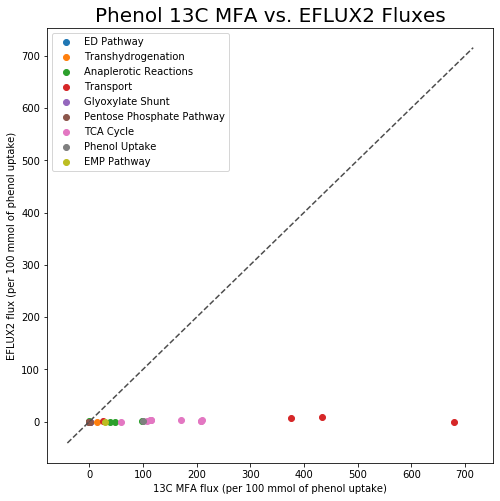

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['EFLUX2 Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. EFLUX2 Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'EFLUX2 flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

### Plot SPOT vs 13C MFA

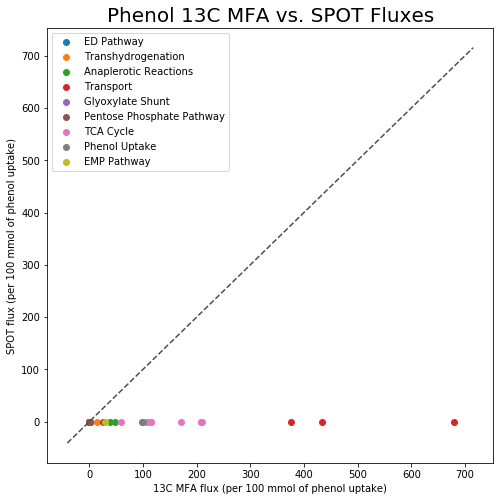

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulatedspot_flux_list = list(pathway_df['SPOT Value'])
    
    ax.scatter(measured_flux_list, simulatedspot_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. SPOT Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'SPOT flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

In [41]:
rxns = [r.id for r in model.reactions]
# #EFlux2_fluxdict = dict(zip(rxns,EFlux2_min.solution.get_values()))
# EFlux2_fluxdict = dict(zip(rxns,eflux2solfluxes.to_numpy()))#replace previous .get_values()
# SPOT_fluxdict = dict(zip(rxns,spotsolWTPR1.to_numpy()))#replace previous .get_values()
# #display(SPOT_fluxdict)

In [42]:
#Scatterplot of solutions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]
    
def scatterplotcompare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    #res = stats.linregress(observed.to_numpy().astype(float), predicted.to_numpy())
    #print(res.rvalue**2)
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    #ax.plot([0.0, 0.2], [0.0, 0.2], 'k',  c='0.55')
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        #ax.annotate(str(labels[i]),(observed[i],predicted[i]))
    #ax.annotate("r-squared = {:.3f}".format(round(r2_score(observed, predicted))), (0, 1))
    #plt.plot(observed, res.intercept + res.slope*observed, 'k', label='fitted line')
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    r2_1 = np.round(1 - rss / tss,2)
    #display(r2_1)
    #r2 = round(r2_score(observed, predicted),2)
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    #display(rmse)
    #display(r2_score(observed, predicted))
    mae_score = np.round(maefunc(observed, predicted),2)
    plt.xlabel(r'EFLUX2')#Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'SPOT')#Predicted growth rates [$mmol/gDW/hr$]')
    #plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={r2_1}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.title(r'EFLUX2 vs. SPOT ('+strtitle+'), \n' + f"$R^2$={r2_1}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

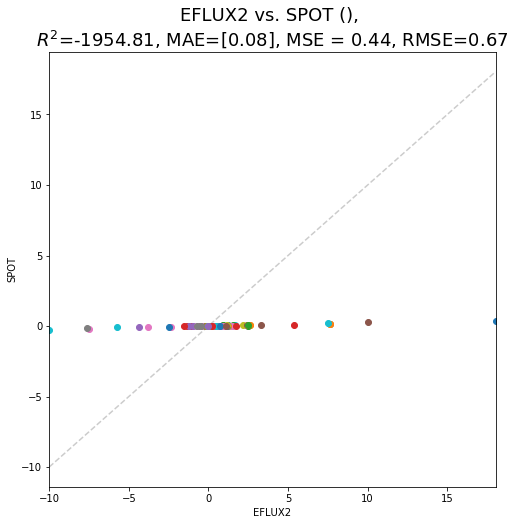

In [43]:
scatterplotcompare(eflux2soldf.to_numpy(), spotsoldf.to_numpy(), labels='', strtitle='')

/usr/local/share/jupyteruser/.pyenv/versions/biod_3.7/lib/python3.7/site-packages/ipykernel_launcher.py:39 RuntimeWarning: divide by zero encountered in double_scalars


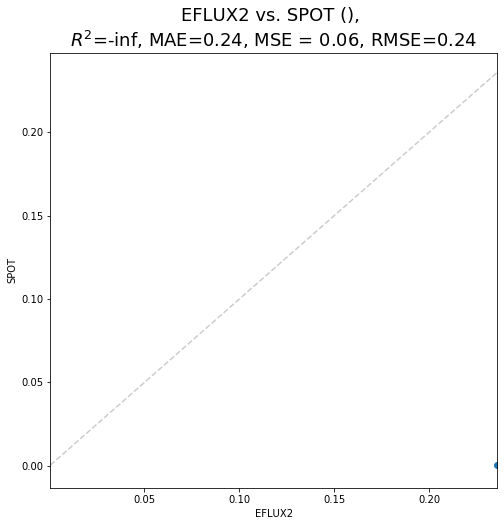

In [44]:
scatterplotcompare(eflux2soldf.loc['Growth_Phenol',:], spotsoldf.loc['Growth_Phenol',:], labels='Growth', strtitle='')